### Hypothesis

Research Question:
Is influence of individual Robinhood investors on a stock's risk level different for small companies versus large companies?

Hypothesis and Regression Specification:
Yes, a positive change in Robinhood holdings will have a more pronounced positive effect on volatility for smaller firms.

Null Hypothesis ($H_0$): The influence of Robinhood accounts changes on volatility is the same for all firms, regardless of their market size. (Key coefficient is zero.)

Main Regression Specification: Pooled OLS Regression model. Main objective is to estimate the coefficient $\beta_4$, which captures the interaction effect between Robinhood attention and firm size. Use squared returns ($R_{i,t}^2$) as the measure for next-day volatility. $$R_{i,t}^2 = \alpha + \beta_1 R_{i,t-1}^2 + \beta_2 \Delta \text{RH}_{i,t-1} + \beta_3 \text{SIZE}_i + \beta_4 (\Delta \text{RH}_{i,t-1} \times \text{SIZE}_i) + \eta_{i,t}$$
- $\mathbf{R_{i,t}^2}$: Next-Day Volatility. The squared daily return, which is our proxy for how risky or volatile the stock was.
- $\mathbf{R_{i,t-1}^2}$: Lagged Volatility. Yesterday's volatility. This controls for the tendency of high-volatility days to follow each other.
- $\mathbf{\Delta \text{RH}_{i,t-1}}$: Robinhood Attention. The percentage change in Robinhood account holders, measured on the previous day.
- $\mathbf{\text{SIZE}_i}$: Firm Size. A rank based on market capitalization, where a higher value means a relatively smaller company.
- $\mathbf{\beta_4 (\Delta \text{RH}_{i,t-1} \times \text{SIZE}_i)}$: Key Test. This is the combined effect of Robinhood attention and small size. If $\beta_4$ is positive and significant, hypothesis is supported.
- $\eta_{i,t}$: Error Term.

### Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import statsmodels.api as sm
import os 

# Sample period
START_DATE_RH = '2018-05-01'
END_DATE_RH = '2020-08-31'

# Tickers for Analysis (Are local files)
TICKERS = ['AAPL', 'PFE', 'JPM', 'NKE'] 

# Determine full period needed for yfinance data
START_DATE_YF = (pd.to_datetime(START_DATE_RH) - timedelta(days=10)).strftime('%Y-%m-%d')
END_DATE_YF = (pd.to_datetime(END_DATE_RH)).strftime('%Y-%m-%d')

print(f"Working with {len(TICKERS)} local tickers: {TICKERS}")
print(f"Fetching daily data from {START_DATE_YF} to {END_DATE_YF}...")

# Function to Read and Process LOCAL Robinhood Data
def process_robinhood_data(ticker, start_date, end_date):
    file_path = f'{ticker}.csv'
    
    if not os.path.exists(file_path):
        print(f"ERROR: Robinhood data file not found locally: {file_path}. Halting.")
        raise FileNotFoundError(f"Missing required file: {file_path}")
        
    try:
        # READ FROM LOCAL FILE
        df_rh = pd.read_csv(file_path)
        
        # Correct timestamp is datetime and clean data
        df_rh['timestamp'] = pd.to_datetime(df_rh['timestamp'])
        df_rh = df_rh.sort_values('timestamp')

        # Find last observed users_holding for each day (EOD proxy)
        eod_rh = df_rh.set_index('timestamp')['users_holding'].resample('D').last().ffill().dropna()
        
        # Calculate daily percentage change in users holding: Delta RH (ΔRH_t)
        delta_rh = eod_rh.pct_change() * 100
        
        delta_rh = delta_rh.reset_index()
        delta_rh.columns = ['Date', 'Delta_RH']
        delta_rh['Ticker'] = ticker
        
        # Filter dates to project window
        delta_rh = delta_rh[(delta_rh['Date'] >= start_date) & (delta_rh['Date'] <= end_date)]
        
        return delta_rh
    except Exception as e:
        print(f"Could not process local RH data for {ticker}. Skipping. Error: {e}")
        return None

# Process All Robinhood Tickers (LOCAL)
print(f"\nProcessing LOCAL RH data for {len(TICKERS)} tickers...")
all_rh_data = []
for ticker in TICKERS:
    rh_df = process_robinhood_data(ticker, START_DATE_RH, END_DATE_RH)
    if rh_df is not None and not rh_df.empty:
        all_rh_data.append(rh_df)

# Concatenate all individual ticker dataframes
RH_data_panel = pd.concat(all_rh_data, ignore_index=True)
RH_data_panel['Date'] = pd.to_datetime(RH_data_panel['Date']).dt.normalize()
RH_data_panel = RH_data_panel.dropna(subset=['Delta_RH']).reset_index(drop=True)
print(f"Loaded {len(RH_data_panel)} daily Robinhood observations from local files.")


# Download and Process Daily Stock Price Data (Y Variable and Lagged Control)
print(f"\nDownloading daily price data...")
prices_raw = yf.download(TICKERS, start=START_DATE_YF, end=END_DATE_YF, 
                         progress=False, auto_adjust=True)

# Extract adjusted close prices and standardize format
prices = prices_raw['Close'] if isinstance(prices_raw.columns, pd.MultiIndex) else prices_raw['Close'].to_frame(name=TICKERS[0])

# Calculate daily returns (R_i,t) and squared returns (R^2_i,t)
daily_returns = prices.pct_change().stack().reset_index()
daily_returns.columns = ['Date', 'Ticker', 'R_t'] 
daily_returns['Date'] = pd.to_datetime(daily_returns['Date']).dt.normalize()
daily_returns['R2_t'] = daily_returns['R_t']**2 

# Calculate lagged squared return (R^2_i,t-1)
daily_returns['R2_t_minus_1'] = daily_returns.groupby('Ticker')['R2_t'].shift(1)


# Create SIZE Proxy (Market Capitalization Rank)
print("\nFetching Market Cap data for SIZE Proxy...")
market_caps = {}
for ticker in TICKERS:
    try:
        info = yf.Ticker(ticker).info
        market_cap = info.get('marketCap', np.nan) 
        market_caps[ticker] = market_cap
    except Exception as e:
        print(f"Market cap fetch failed for {ticker}. Skipping from SIZE calculation.")
        market_caps[ticker] = np.nan

size_df = pd.Series(market_caps).dropna().to_frame(name='MarketCap_USD')

size_df = size_df.reset_index(names=['Ticker'])

# RANKING: Assign a higher SIZE_Proxy number to a smaller firm.
size_df['SIZE_Proxy'] = size_df['MarketCap_USD'].rank(ascending=True, method='dense') 
# Normalize SIZE proxy
max_rank = size_df['SIZE_Proxy'].max()
size_df['SIZE_Proxy'] = size_df['SIZE_Proxy'] / max_rank 

print(f"SIZE Proxy calculated for {len(size_df)} firms.")


# Merge 1: Returns and RH Data (on Date and Ticker)
regression_data = pd.merge(daily_returns, RH_data_panel, on=['Date', 'Ticker'], how='inner')

# RH variable needs to be lagged by one day: Delta RH_t-1
regression_data['Delta_RH_t_minus_1'] = regression_data.groupby('Ticker')['Delta_RH'].shift(1)

# Merge 2: Add SIZE Proxy (on Ticker)
regression_data = pd.merge(regression_data, size_df[['SIZE_Proxy', 'Ticker']], on='Ticker', how='left') 

# Create Interaction Term: (Delta RH_t-1 * SIZE_i)
regression_data['Delta_RH_x_SIZE'] = regression_data['Delta_RH_t_minus_1'] * regression_data['SIZE_Proxy']

# Final Cleanup
regression_data = regression_data.dropna().reset_index(drop=True)

print(f"\nFinal regression sample size (rows): {len(regression_data)}")
print(regression_data[['Date', 'Ticker', 'R2_t', 'R2_t_minus_1', 'Delta_RH_t_minus_1', 'SIZE_Proxy', 'Delta_RH_x_SIZE']].head())

Working with 4 local tickers: ['AAPL', 'PFE', 'JPM', 'NKE']
Fetching daily data from 2018-04-21 to 2020-08-31...

Processing LOCAL RH data for 4 tickers...
Loaded 3336 daily Robinhood observations from local files.


Fetching Market Cap data for SIZE Proxy...
SIZE Proxy calculated for 4 firms.

Final regression sample size (rows): 2296
        Date Ticker      R2_t  R2_t_minus_1  Delta_RH_t_minus_1  SIZE_Proxy  \
0 2018-05-04   AAPL  0.001539      0.000003           -4.667573        1.00   
1 2018-05-04    JPM  0.000123      0.000040            0.558230        0.75   
2 2018-05-04    NKE  0.000322      0.000397            0.221298        0.25   
3 2018-05-04    PFE  0.000005      0.000014            0.500825        0.50   
4 2018-05-07   AAPL  0.000052      0.001539           -1.616034        1.00   

   Delta_RH_x_SIZE  
0        -4.667573  
1         0.418673  
2         0.055325  
3         0.250413  
4        -1.616034  


### Regression Specification(s)

In [2]:
# Define Y (Dependent Variable: R^2_i,t - Daily Squared Return)
Y = regression_data['R2_t']

# Define X (Independent Variables from hypothesis)
# X_vars: R2_t-1, Delta_RH_t-1, SIZE_Proxy, Delta_RH_x_SIZE
X_vars = ['R2_t_minus_1', 'Delta_RH_t_minus_1', 'SIZE_Proxy', 'Delta_RH_x_SIZE']
X = regression_data[X_vars]
X = sm.add_constant(X)

my_y = Y.to_numpy()
my_X = X.to_numpy()

# Create date array
my_dates = (
    regression_data[['Date', 'Ticker']]
    .drop_duplicates()
    .sort_values(['Ticker', 'Date'])
    ['Date']
    .dt.strftime('%Y-%m-%d')
    .to_numpy()
)

# Save files
np.save('my_y.npy', my_y)
np.save('my_X.npy', my_X)
np.save('my_dates.npy', my_dates)

# Estimate Pooled OLS Regression
print("\nEstimating Pooled OLS Regression...")
model = sm.OLS(Y, X)
main_regression_result = model.fit()

# Output
print("\n" + "="*80)
print("MAIN REGRESSION: RH Attention Predicting Volatility with Size Interaction")
print("Dependent Variable: Daily Squared Return (R2_t, Proxy for Volatility)")
print("Null Hypothesis (H0): Coefficient on Delta_RH_x_SIZE is zero (Beta_4 = 0)")
print("SIZE_Proxy: Higher value means relatively smaller firm.")
print("="*80)
print(main_regression_result.summary(
    xname=['Intercept', 'R2_t-1', 'Delta_RH_t-1', 'SIZE_Proxy', 'Delta_RH_x_SIZE']
))


Estimating Pooled OLS Regression...

MAIN REGRESSION: RH Attention Predicting Volatility with Size Interaction
Dependent Variable: Daily Squared Return (R2_t, Proxy for Volatility)
Null Hypothesis (H0): Coefficient on Delta_RH_x_SIZE is zero (Beta_4 = 0)
SIZE_Proxy: Higher value means relatively smaller firm.
                            OLS Regression Results                            
Dep. Variable:                   R2_t   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     138.8
Date:                Mon, 23 Feb 2026   Prob (F-statistic):          2.51e-106
Time:                        15:20:20   Log-Likelihood:                 11833.
No. Observations:                2296   AIC:                        -2.366e+04
Df Residuals:                    2291   BIC:                        -2.363e+04
Df Model:                           4                   

### Interpretation and Conclusion

Based on the results from the regression, reject the null hypothesis that the coefficient on the interaction term ($\Delta \text{RH}_{i,t-1} \times \text{SIZE}_i$) is zero, using the standard 99% confidence level (since the P-value was $0.000$). The positive and highly significant coefficient on the interaction term ($\beta_4=0.0004$) says that the predictive power of increased Robinhood attention on next-day stock volatility is significantly greater for smaller firms (those with a higher $\text{SIZE}$ proxy value) than for larger firms, validating the research hypothesis that retail trading disproportionately impacts the market behavior of smaller stocks. Moving forward, to further explore this phenomenon, future research should incorporate firm fixed effects to control for unobserved, time-invariant differences between companies (like brand value or risk tolerance) and could also be expanded to include data on short interest as a control variable, testing whether the "Robinhood effect" is distinct from general speculative short squeezes.

<Figure size 1200x700 with 0 Axes>

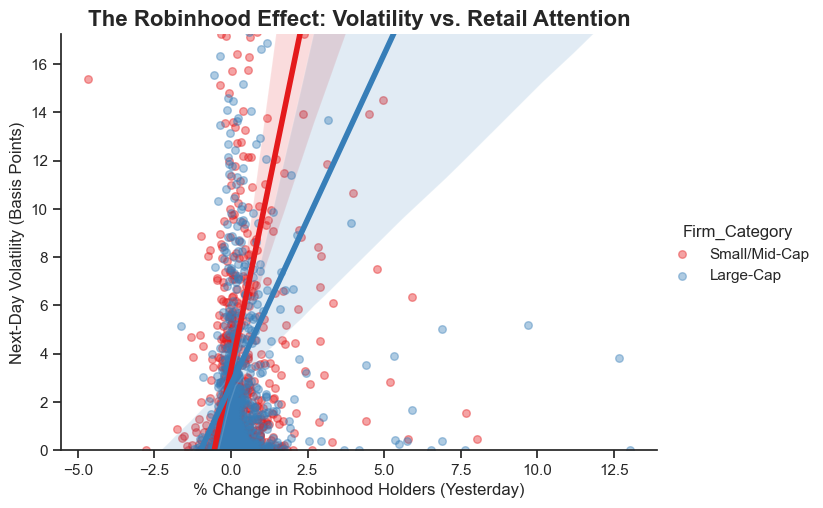

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

viz_df = plot_df.copy()
viz_df['Volatility_BPS'] = viz_df['R2_t'] * 10000

mask = (viz_df['Delta_RH_t_minus_1'] >= -10) & (viz_df['Delta_RH_t_minus_1'] <= 20)
viz_df = viz_df[mask]

plt.figure(figsize=(12, 7))
sns.set_style("ticks")

g = sns.lmplot(
    x='Delta_RH_t_minus_1', 
    y='Volatility_BPS', 
    hue='Firm_Category', 
    data=viz_df,
    palette='Set1',
    scatter_kws={'alpha': 0.4, 's': 30},
    line_kws={'linewidth': 4},
    aspect=1.4,
    truncate=False
)

plt.title('The Robinhood Effect: Volatility vs. Retail Attention', fontsize=16, fontweight='bold')
plt.xlabel('% Change in Robinhood Holders (Yesterday)', fontsize=12)
plt.ylabel('Next-Day Volatility (Basis Points)', fontsize=12)

plt.ylim(0, viz_df['Volatility_BPS'].quantile(0.95)) 

plt.show()